# Alphabet image generation

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow import keras
from tensorflow.keras import layers
import os

# Downloading data

In [ ]:
pip install extra-keras-datasets

  Created wheel for extra-keras-datasets: filename=extra_keras_datasets-0.1.7-cp36-none-any.whl size=7311 sha256=7f6c57521dc28238c002ff4e38334e65137b18735f3cf793750364e494cb8821
  Stored in directory: /root/.cache/pip/wheels/8a/04/95/e8f214025c2e40d5618a443e4ea09df0031050b35460ea007c
Successfully built extra-keras-datasets


In [ ]:
from extra_keras_datasets import emnist

743907328/743900280 [==============================] - 49s 0us/step
label:  7


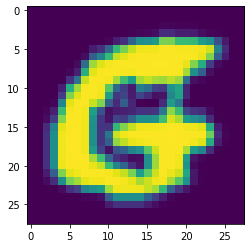

In [ ]:
(train_images,train_labels),(test_images,test_labels) = emnist.load_data(type='letters')
plt.imshow(train_images[1])
print ("label: ", train_labels[1])

# Extracting images for "G" character

In [ ]:
letter_G_images = []
for i in range(len(train_images)):
    if train_labels[i] == 7:
        letter_G_images.append(train_images[i])
train_images = np.array(letter_G_images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


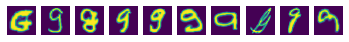

In [ ]:
n = 10
f = plt.figure()
for i in range(n):
    f.add_subplot(1, n, i + 1)
    plt.subplot(1, n, i+1 ).axis("off")
    plt.imshow(train_images[i])
plt.show()

# Preparing dataset

In [ ]:
train_images = train_images.reshape (
    train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(train_images.shape[0]).batch(32)

##Creating generator model

In [ ]:
gen_model = tf.keras.Sequential()

# Feed network with a 7x7 random image
gen_model.add(tf.keras.layers.Dense(7*7*256, 
                                    use_bias=False, 
                                    input_shape=(100,)))
# Add batch normalization for stability 
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# reshape the output
gen_model.add(tf.keras.layers.Reshape((7, 7, 256)))

# Apply (5x5) filter and shift of (1,1). 
# The image output is still 7x7.  
gen_model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), 
                                              strides=(1, 1), 
                                              padding='same', 
                                              use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# apply stride of (2,2). The output image is now 14x14.
gen_model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), 
                                              strides=(2, 2), 
                                              padding='same', 
                                              use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# another shift upscales the image to 28x28, which is our final size.
gen_model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), 
                                              strides=(2, 2), 
                                              padding='same', 
                                              use_bias=False, 
                                              activation='tanh'))

In [ ]:
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

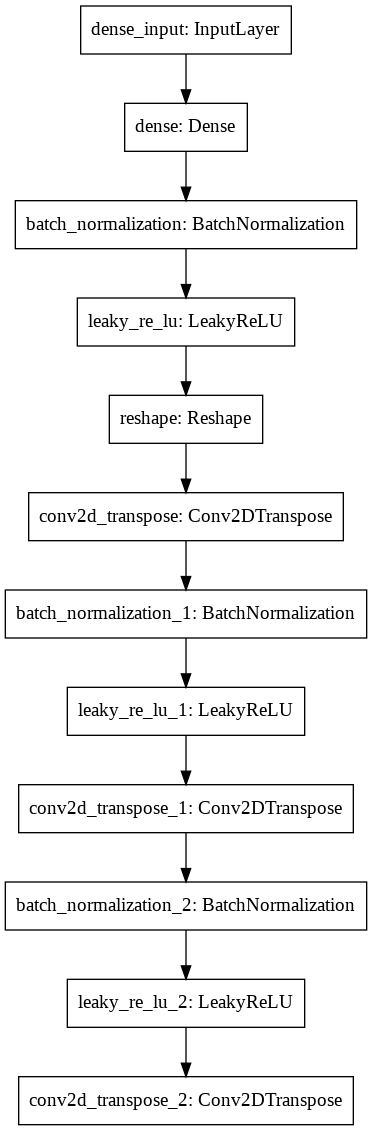

In [ ]:
tf.keras.utils.plot_model(gen_model)

# Testing image generator with random input vector

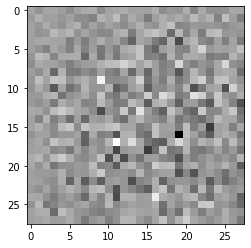

In [ ]:
noise = tf.random.normal([1, 100])#giving random input vector
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

# Defining descriminator model

In [ ]:
discri_model = tf.keras.Sequential()

discri_model.add(tf.keras.layers.Conv2D(64, (5, 5), 
                                        strides=(2, 2), 
                                        padding='same',
                                        input_shape=[28, 28, 1]))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
      
discri_model.add(tf.keras.layers.Conv2D(128, (5, 5), 
                                        strides=(2, 2), 
                                        padding='same'))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))

discri_model.add(tf.keras.layers.Flatten())
discri_model.add(tf.keras.layers.Dense(1))

In [ ]:
discri_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

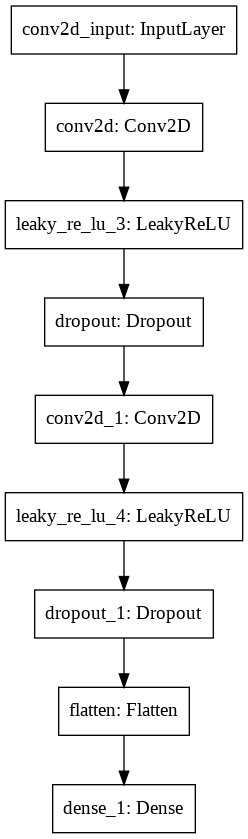

In [ ]:
tf.keras.utils.plot_model(discri_model)

# Testing discriminator

In [ ]:
decision = discri_model(generated_image)
print (decision)

tf.Tensor([[0.00090674]], shape=(1, 1), dtype=float32)


# Loss functions

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #creating loss function

In [ ]:
def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output),generated_output)

In [ ]:
def discriminator_loss(real_output, generated_output):
    # compute loss considering the image is real [1,1,...,1]
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)

    # compute loss considering the image is fake[0,0,...,0]
    generated_loss = cross_entropy(tf.zeros_like(generated_output),
                                   generated_output)

    # compute total loss
    total_loss = real_loss + generated_loss

    return total_loss

# Optimizers

In [ ]:
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

## Setting up a few variables

In [ ]:
epoch_number = 0
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([1, noise_dim])

In [ ]:
checkpoint_dir = '/content/drive/My Drive/GAN2/Checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=discri_optimizer, 
                                 generator= gen_model,
                                 discriminator = discri_model)

## Mounting drive for storing images and checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/GAN2'

/content/drive/My Drive/GAN2


# Gradient tuning function

In [ ]:
def gradient_tuning(images):
    # create a noise vector.
    noise = tf.random.normal([16, noise_dim])

    # Use gradient tapes for automatic differentiation 
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape: 

      # ask genertor to generate random images
      generated_images = gen_model(noise, training=True)

      # ask discriminator to evalute the real images and generate its output
      real_output = discri_model(images, training=True)

      # ask discriminator to do the evlaution on generated (fake) images
      fake_output = discri_model(generated_images, training=True)

      # calculate generator loss on fake data
      gen_loss = generator_loss(fake_output)

      # calculate discriminator loss as defined earlier
      disc_loss = discriminator_loss(real_output, fake_output)

    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, 
                                               gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, 
                                        discri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, 
                                            gen_model.trainable_variables))
    
    # same as above to discriminator
    discri_optimizer.apply_gradients(
        zip(discri_gradients, 
            discri_model.trainable_variables))

# Function for generating images at every epoch

In [ ]:
    def generate_and_save_images(model, epoch, test_input):
        # use a global count for tracking epochs in case of disconnection
        global epoch_number
        epoch_number = epoch_number + 1

        # set training to false to ensure inference mode
        predictions = model(test_input, training=False)

        # display and save image
        fig = plt.figure(figsize=(4,4))
        for i in range(predictions.shape[0]):
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
        plt.show()

# Setting up a training loop

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gradient_tuning(image_batch)
    
    # Produce images as we go
    generate_and_save_images(gen_model,
                             epoch + 1,
                             seed)
    
    # save checkpoint data
    checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, 
                                                time.time()-start))

# Model training

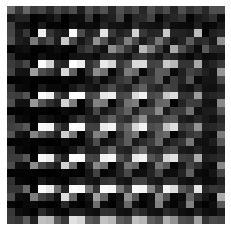

Time for epoch 1 is 10.143789052963257 sec


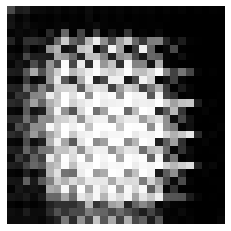

Time for epoch 2 is 9.481556177139282 sec


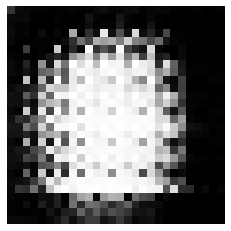

Time for epoch 3 is 9.545110702514648 sec


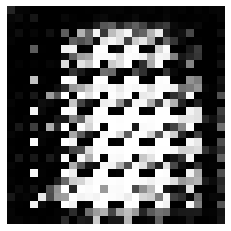

Time for epoch 4 is 9.476449251174927 sec


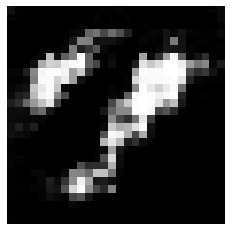

Time for epoch 5 is 9.577216863632202 sec


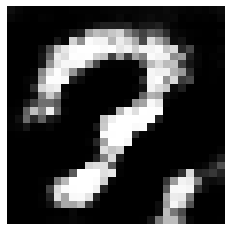

Time for epoch 6 is 9.518744468688965 sec


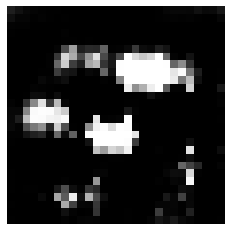

Time for epoch 7 is 9.467342376708984 sec


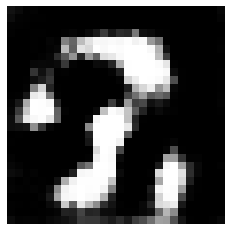

Time for epoch 8 is 9.387022256851196 sec


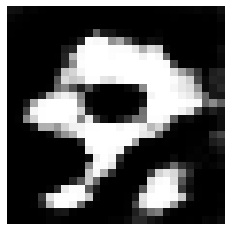

Time for epoch 9 is 9.440960168838501 sec


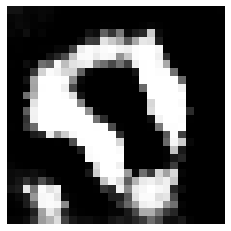

Time for epoch 10 is 9.345218896865845 sec


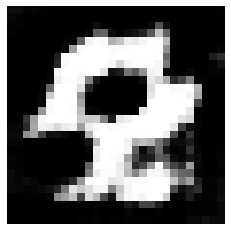

Time for epoch 11 is 9.42484974861145 sec


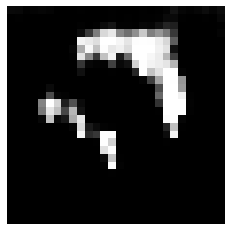

Time for epoch 12 is 9.40428113937378 sec


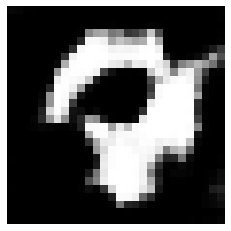

Time for epoch 13 is 9.333271980285645 sec


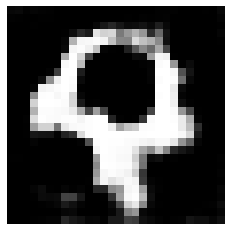

Time for epoch 14 is 9.60757327079773 sec


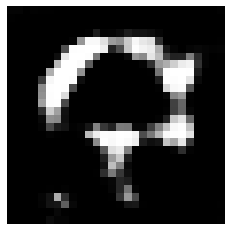

Time for epoch 15 is 9.711796045303345 sec


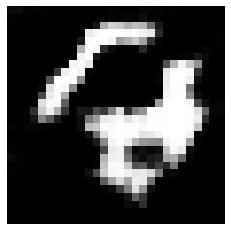

Time for epoch 16 is 9.535029411315918 sec


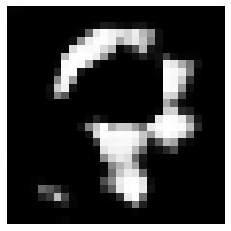

Time for epoch 17 is 9.370999813079834 sec


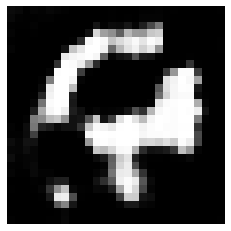

Time for epoch 18 is 9.379538774490356 sec


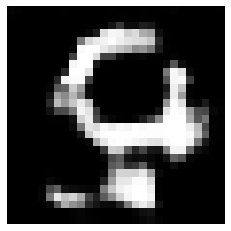

Time for epoch 19 is 9.425729990005493 sec


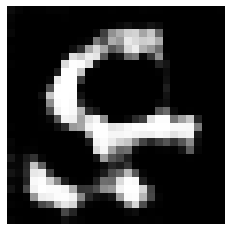

Time for epoch 20 is 9.559988498687744 sec


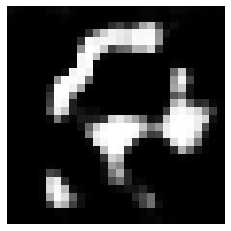

Time for epoch 21 is 9.525684833526611 sec


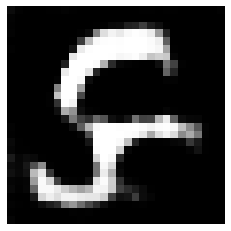

Time for epoch 22 is 9.55514407157898 sec


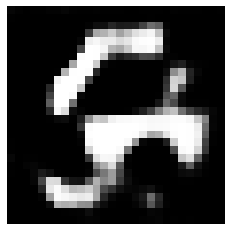

Time for epoch 23 is 9.540889978408813 sec


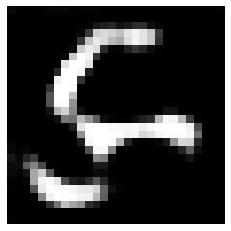

Time for epoch 24 is 9.458121299743652 sec


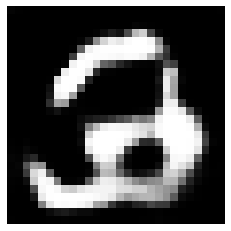

Time for epoch 25 is 9.363501071929932 sec


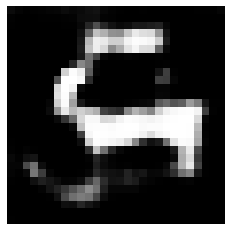

Time for epoch 26 is 9.501198768615723 sec


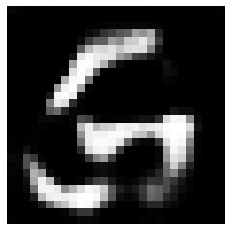

Time for epoch 27 is 9.419123649597168 sec


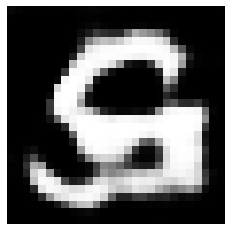

Time for epoch 28 is 9.614474058151245 sec


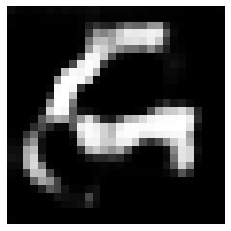

Time for epoch 29 is 9.950977563858032 sec


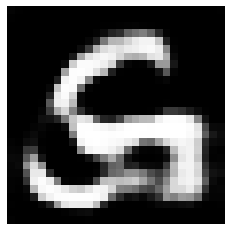

Time for epoch 30 is 9.53602123260498 sec


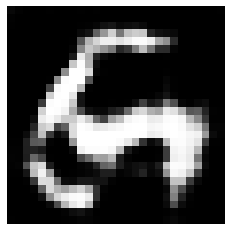

Time for epoch 31 is 9.636048078536987 sec


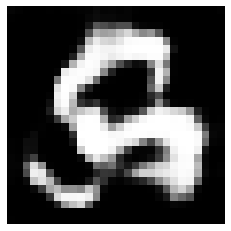

Time for epoch 32 is 9.513606548309326 sec


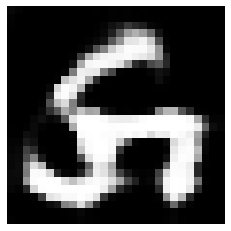

Time for epoch 33 is 9.471886157989502 sec


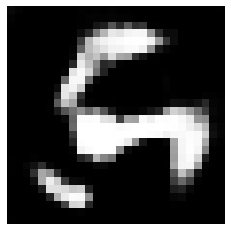

Time for epoch 34 is 9.570388078689575 sec


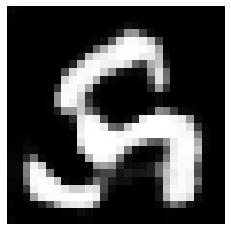

Time for epoch 35 is 9.468826293945312 sec


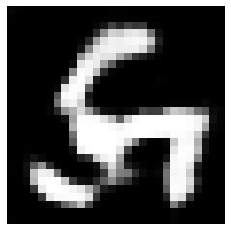

Time for epoch 36 is 9.52709674835205 sec


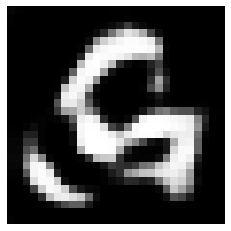

Time for epoch 37 is 9.402833700180054 sec


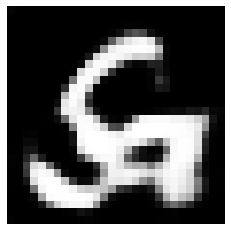

Time for epoch 38 is 9.54772663116455 sec


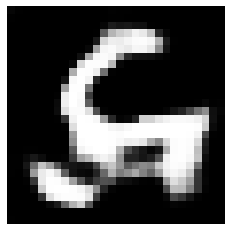

Time for epoch 39 is 9.438095808029175 sec


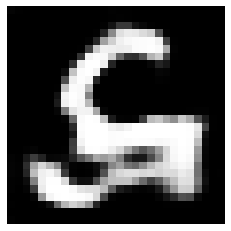

Time for epoch 40 is 9.480717658996582 sec


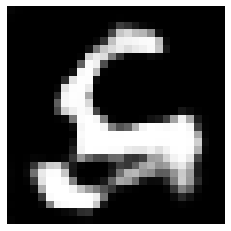

Time for epoch 41 is 9.342203617095947 sec


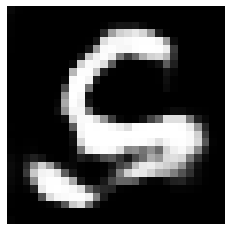

Time for epoch 42 is 9.486635684967041 sec


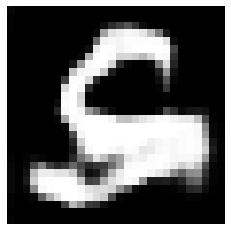

Time for epoch 43 is 10.02107834815979 sec


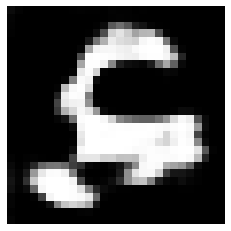

Time for epoch 44 is 9.53736686706543 sec


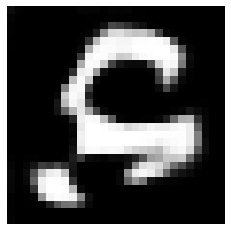

Time for epoch 45 is 9.36325216293335 sec


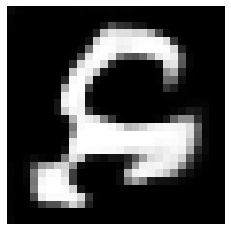

Time for epoch 46 is 9.358885049819946 sec


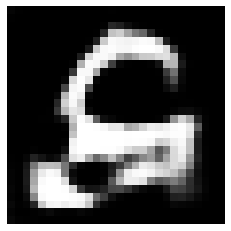

Time for epoch 47 is 9.576332330703735 sec


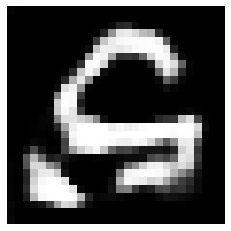

Time for epoch 48 is 9.747359991073608 sec


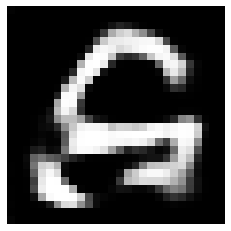

Time for epoch 49 is 9.652454376220703 sec


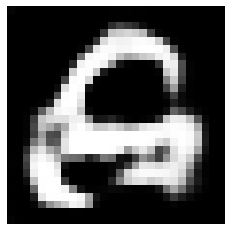

Time for epoch 50 is 9.676674127578735 sec


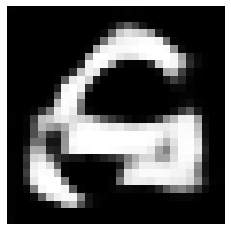

Time for epoch 51 is 9.687026262283325 sec


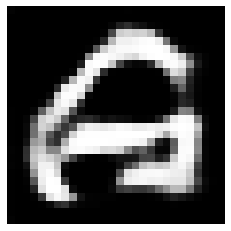

Time for epoch 52 is 9.629602909088135 sec


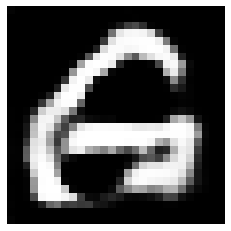

Time for epoch 53 is 9.687697410583496 sec


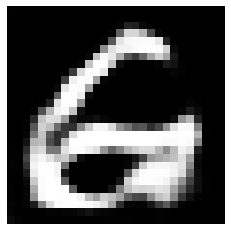

Time for epoch 54 is 9.89551329612732 sec


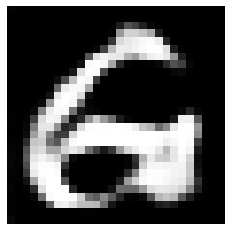

Time for epoch 55 is 9.581323385238647 sec


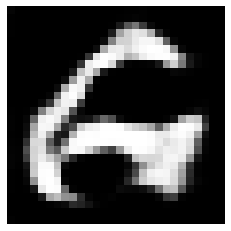

Time for epoch 56 is 9.536133050918579 sec


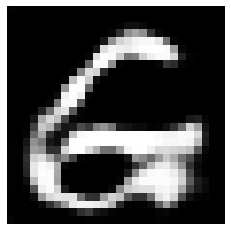

Time for epoch 57 is 10.18446397781372 sec


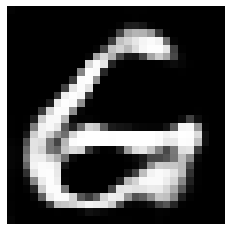

Time for epoch 58 is 9.630826711654663 sec


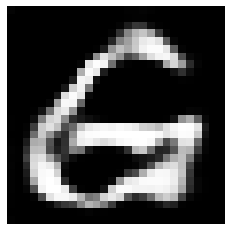

Time for epoch 59 is 9.443415641784668 sec


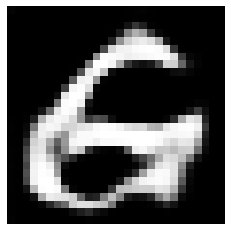

Time for epoch 60 is 9.418656587600708 sec


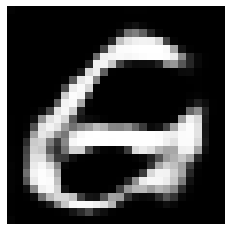

Time for epoch 61 is 9.472625732421875 sec


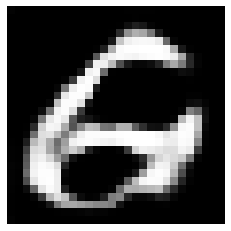

Time for epoch 62 is 9.428045511245728 sec


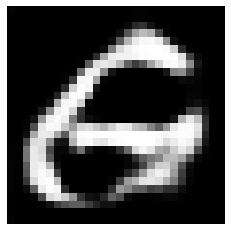

Time for epoch 63 is 9.416695356369019 sec


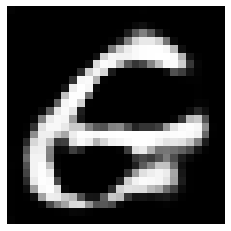

Time for epoch 64 is 9.387465953826904 sec


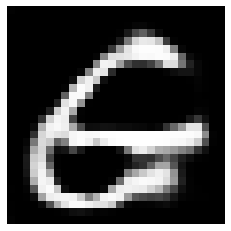

Time for epoch 65 is 9.348734855651855 sec


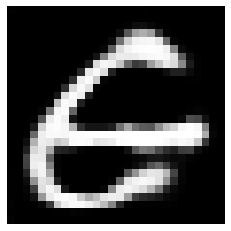

Time for epoch 66 is 9.511973142623901 sec


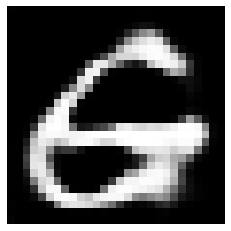

Time for epoch 67 is 9.439388751983643 sec


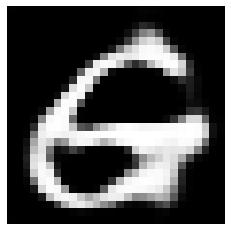

Time for epoch 68 is 9.282194137573242 sec


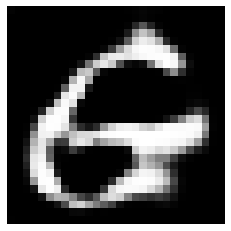

Time for epoch 69 is 9.38584852218628 sec


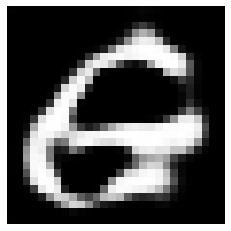

Time for epoch 70 is 9.20816445350647 sec


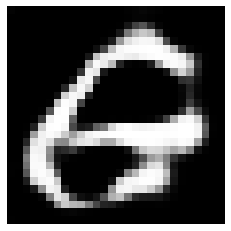

Time for epoch 71 is 9.588048934936523 sec


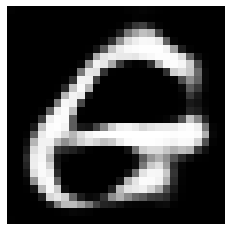

Time for epoch 72 is 9.772382259368896 sec


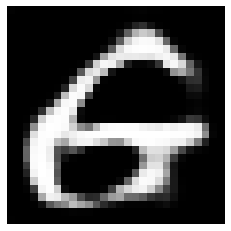

Time for epoch 73 is 9.377382278442383 sec


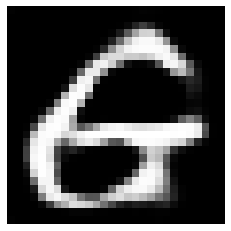

Time for epoch 74 is 9.425040483474731 sec


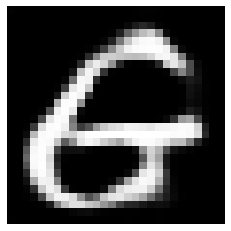

Time for epoch 75 is 9.38597822189331 sec


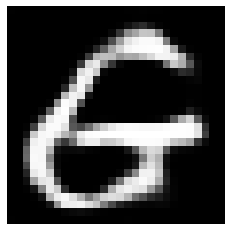

Time for epoch 76 is 9.277128458023071 sec


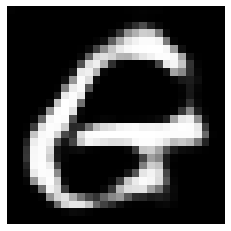

Time for epoch 77 is 9.40614938735962 sec


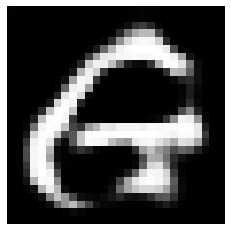

Time for epoch 78 is 9.442568063735962 sec


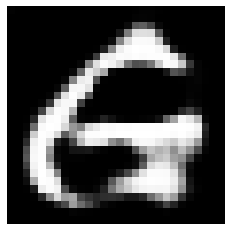

Time for epoch 79 is 9.319280862808228 sec


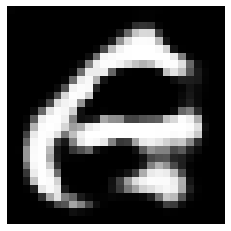

Time for epoch 80 is 9.734067440032959 sec


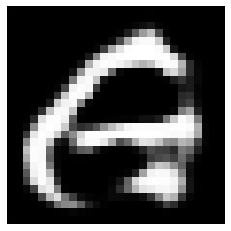

Time for epoch 81 is 9.500972509384155 sec


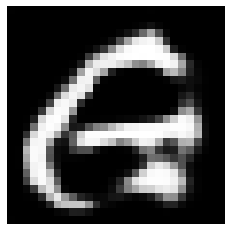

Time for epoch 82 is 9.34410047531128 sec


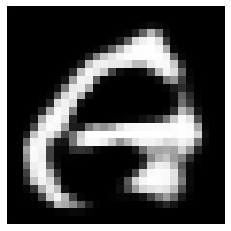

Time for epoch 83 is 9.308278799057007 sec


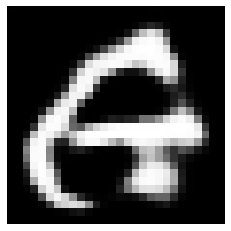

Time for epoch 84 is 9.414681911468506 sec


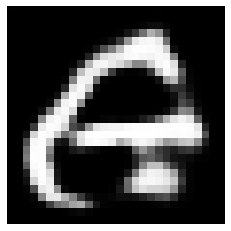

Time for epoch 85 is 9.289527416229248 sec


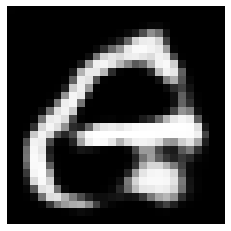

Time for epoch 86 is 9.423920631408691 sec


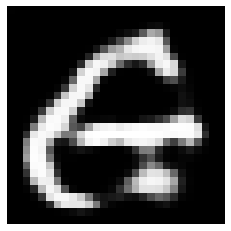

Time for epoch 87 is 9.303550958633423 sec


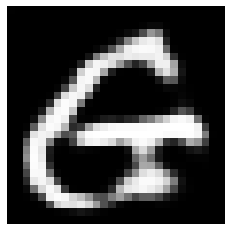

Time for epoch 88 is 9.479864358901978 sec


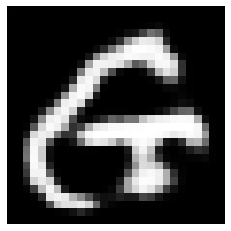

Time for epoch 89 is 9.45441722869873 sec


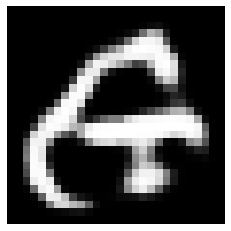

Time for epoch 90 is 9.45673418045044 sec


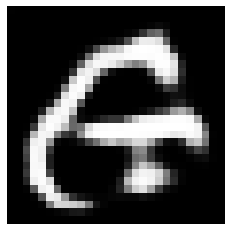

Time for epoch 91 is 9.529529809951782 sec


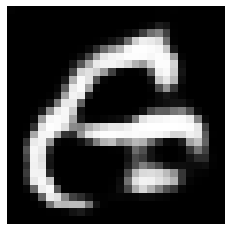

Time for epoch 92 is 9.340703248977661 sec


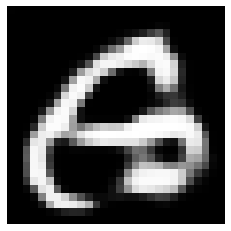

Time for epoch 93 is 9.548977613449097 sec


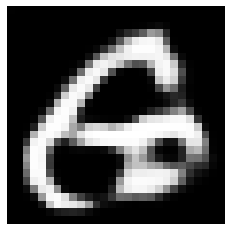

Time for epoch 94 is 9.83669638633728 sec


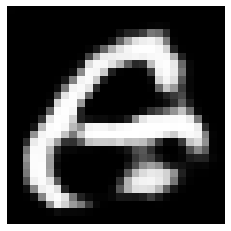

Time for epoch 95 is 9.415196895599365 sec


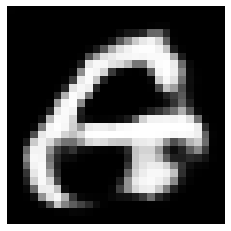

Time for epoch 96 is 9.336403369903564 sec


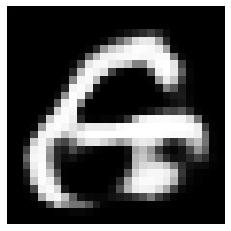

Time for epoch 97 is 9.717106580734253 sec


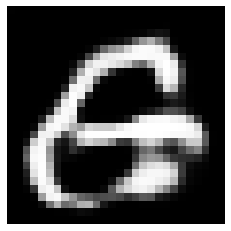

Time for epoch 98 is 9.425707817077637 sec


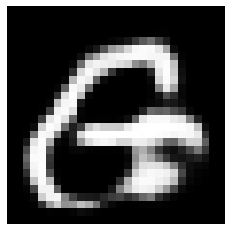

Time for epoch 99 is 9.494484663009644 sec


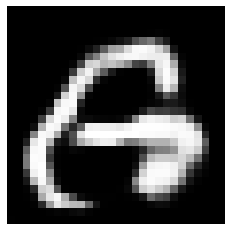

Time for epoch 100 is 9.337046146392822 sec


In [ ]:
train(train_dataset, EPOCHS)

### Run following code only if there is a disconnection and you wish to continue training from the last checkpoint

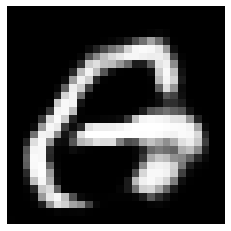

Time for epoch 1 is 9.467432498931885 sec


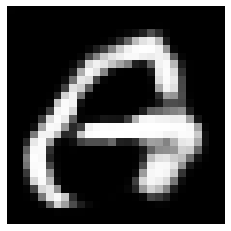

Time for epoch 2 is 9.429395198822021 sec


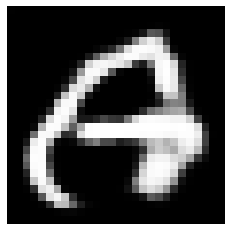

Time for epoch 3 is 9.318919897079468 sec


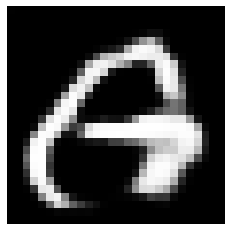

Time for epoch 4 is 9.385883569717407 sec


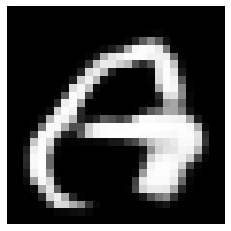

Time for epoch 5 is 10.484946489334106 sec


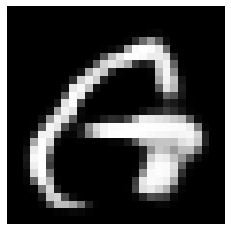

Time for epoch 6 is 9.624058246612549 sec


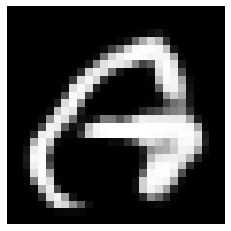

Time for epoch 7 is 9.453826427459717 sec


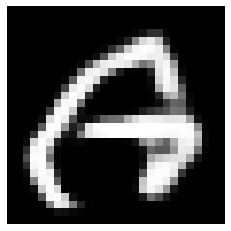

Time for epoch 8 is 9.397281646728516 sec


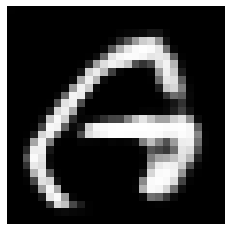

Time for epoch 9 is 9.356874704360962 sec


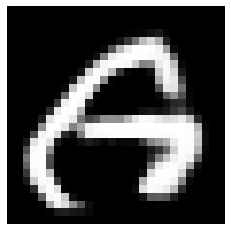

Time for epoch 10 is 9.545773267745972 sec


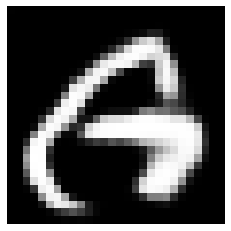

Time for epoch 11 is 8.545620679855347 sec


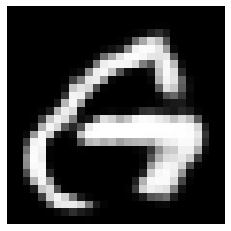

Time for epoch 12 is 8.579460859298706 sec


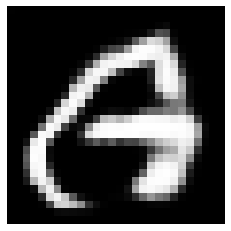

Time for epoch 13 is 8.900668621063232 sec


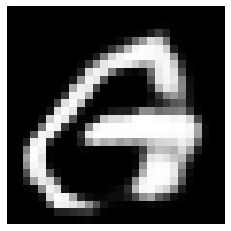

Time for epoch 14 is 8.798378944396973 sec


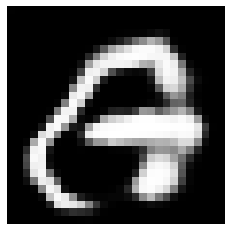

Time for epoch 15 is 8.617382287979126 sec


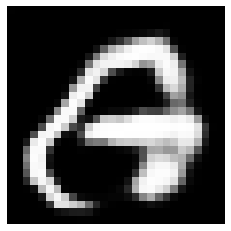

Time for epoch 16 is 8.590522766113281 sec


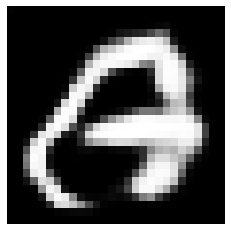

Time for epoch 17 is 8.918571472167969 sec


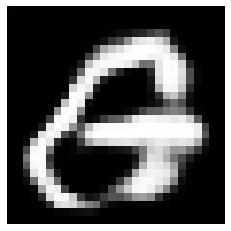

Time for epoch 18 is 8.828748941421509 sec


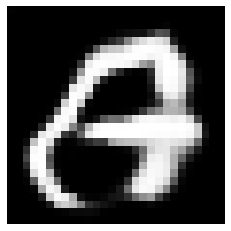

Time for epoch 19 is 8.493003845214844 sec


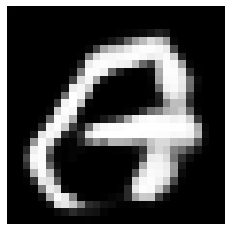

Time for epoch 20 is 8.59352993965149 sec


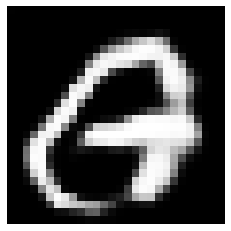

Time for epoch 21 is 8.600345134735107 sec


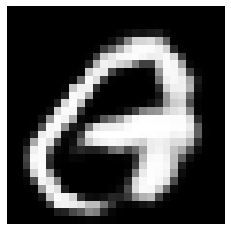

Time for epoch 22 is 8.642121076583862 sec


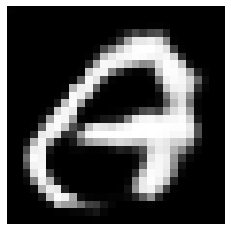

Time for epoch 23 is 8.73090672492981 sec


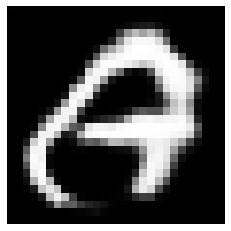

Time for epoch 24 is 9.361358880996704 sec


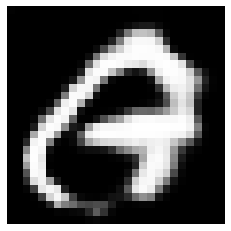

Time for epoch 25 is 8.471338748931885 sec


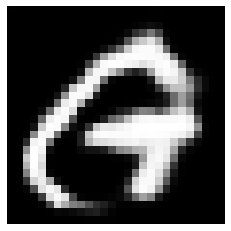

Time for epoch 26 is 8.533574342727661 sec


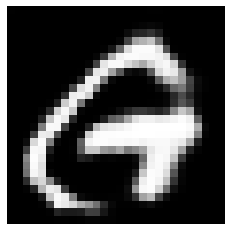

Time for epoch 27 is 8.540408372879028 sec


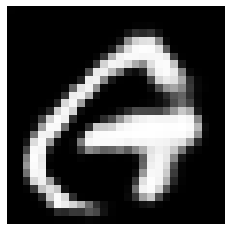

Time for epoch 28 is 8.701127529144287 sec


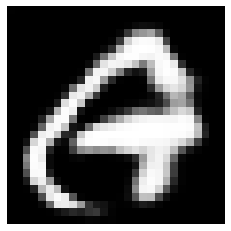

Time for epoch 29 is 8.585719108581543 sec


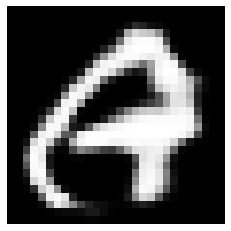

Time for epoch 30 is 8.616891860961914 sec


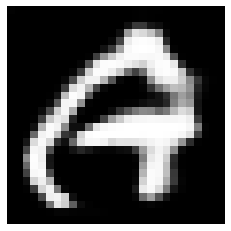

Time for epoch 31 is 8.599661827087402 sec


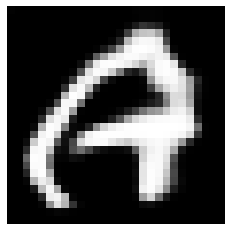

Time for epoch 32 is 8.588401556015015 sec


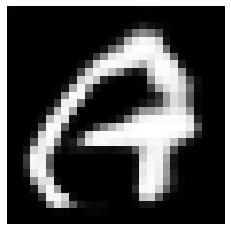

Time for epoch 33 is 8.500183343887329 sec


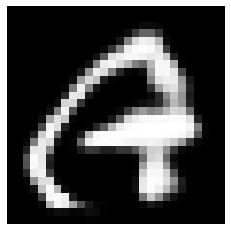

Time for epoch 34 is 8.55990982055664 sec


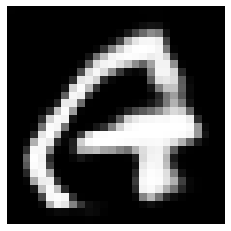

Time for epoch 35 is 8.52835988998413 sec


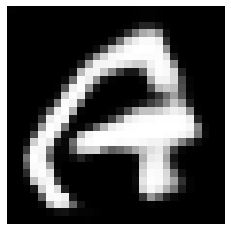

Time for epoch 36 is 8.451708316802979 sec


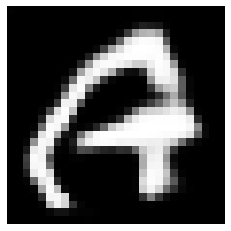

Time for epoch 37 is 8.523131132125854 sec


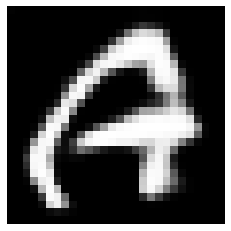

Time for epoch 38 is 8.587486505508423 sec


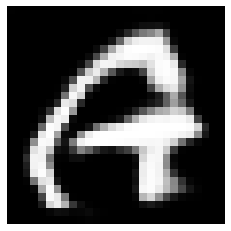

Time for epoch 39 is 8.404438734054565 sec


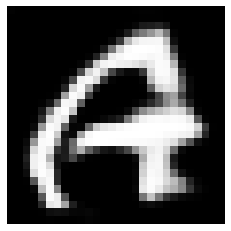

Time for epoch 40 is 8.61854863166809 sec


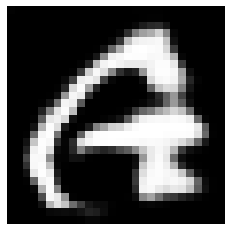

Time for epoch 41 is 8.573857069015503 sec


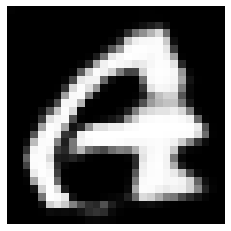

Time for epoch 42 is 8.563796281814575 sec


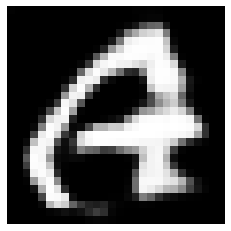

Time for epoch 43 is 8.561384439468384 sec


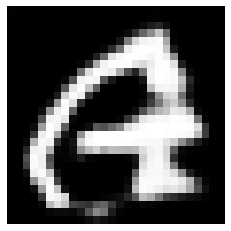

Time for epoch 44 is 8.66136622428894 sec


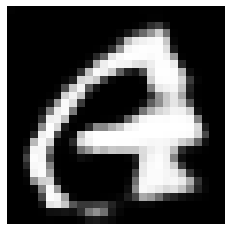

Time for epoch 45 is 8.758525609970093 sec


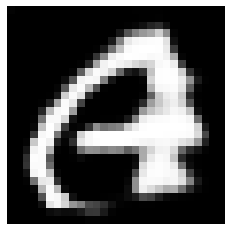

Time for epoch 46 is 8.631205081939697 sec


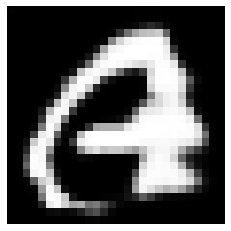

Time for epoch 47 is 9.140481233596802 sec


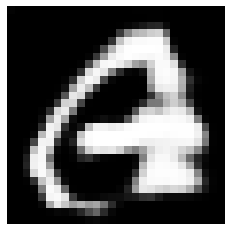

Time for epoch 48 is 8.520497560501099 sec


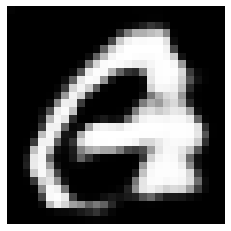

Time for epoch 49 is 8.982545375823975 sec


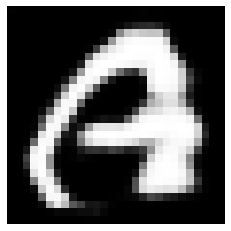

Time for epoch 50 is 8.604732751846313 sec


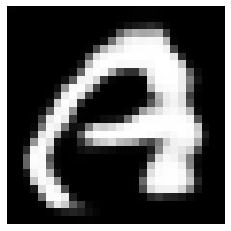

Time for epoch 51 is 8.716038703918457 sec


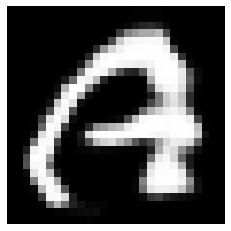

Time for epoch 52 is 8.552151441574097 sec


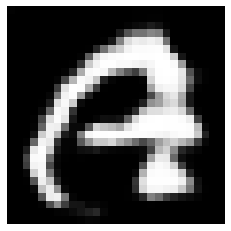

Time for epoch 53 is 8.63715672492981 sec


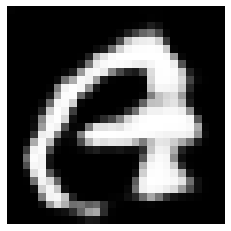

Time for epoch 54 is 8.531810760498047 sec


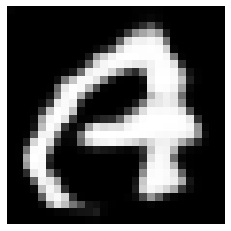

Time for epoch 55 is 8.530263900756836 sec


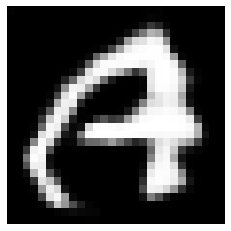

Time for epoch 56 is 8.457345247268677 sec


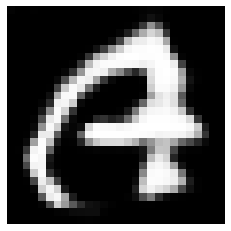

Time for epoch 57 is 8.519274950027466 sec


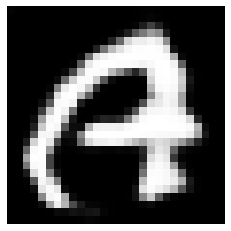

Time for epoch 58 is 8.554105758666992 sec


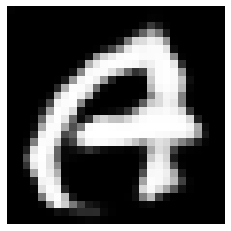

Time for epoch 59 is 8.791945934295654 sec


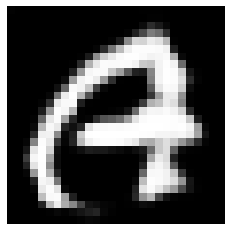

Time for epoch 60 is 8.591863870620728 sec


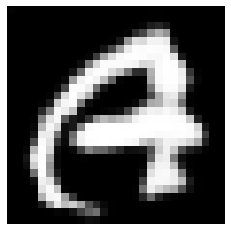

Time for epoch 61 is 9.061842203140259 sec


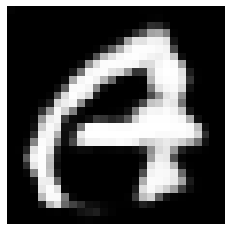

Time for epoch 62 is 8.51427173614502 sec


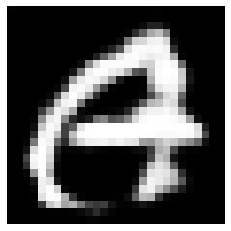

Time for epoch 63 is 8.544562339782715 sec


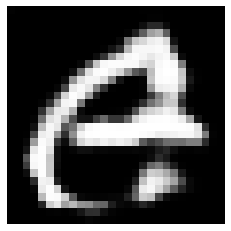

Time for epoch 64 is 8.47172999382019 sec


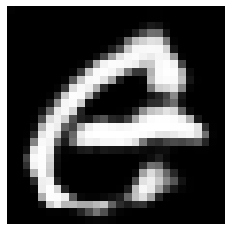

Time for epoch 65 is 8.474859714508057 sec


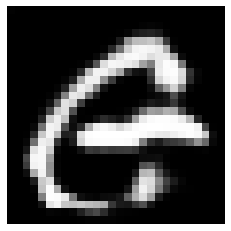

Time for epoch 66 is 8.527409076690674 sec


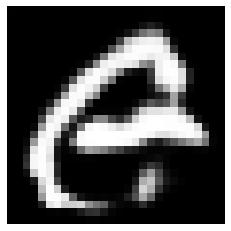

Time for epoch 67 is 8.59030270576477 sec


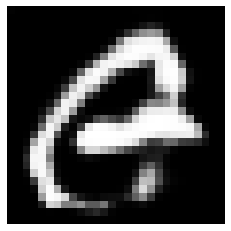

Time for epoch 68 is 8.551400899887085 sec


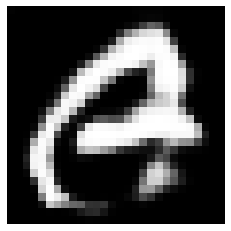

Time for epoch 69 is 8.418937683105469 sec


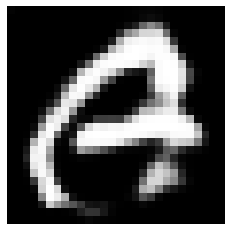

Time for epoch 70 is 8.674177885055542 sec


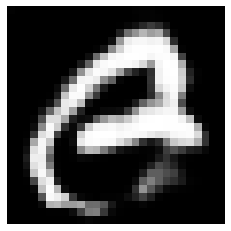

Time for epoch 71 is 8.55972170829773 sec


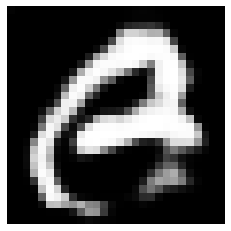

Time for epoch 72 is 8.510162353515625 sec


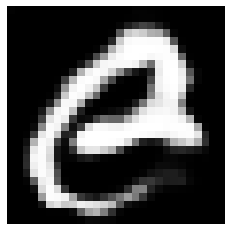

Time for epoch 73 is 8.575185298919678 sec


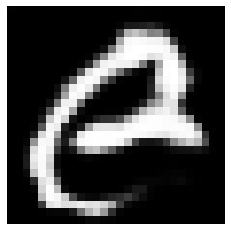

Time for epoch 74 is 8.490031957626343 sec


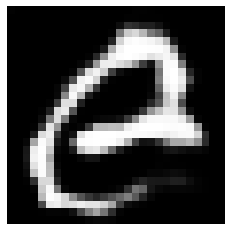

Time for epoch 75 is 8.533753633499146 sec


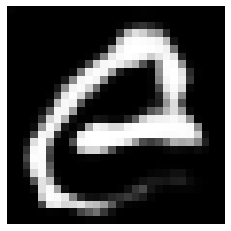

Time for epoch 76 is 8.60884404182434 sec


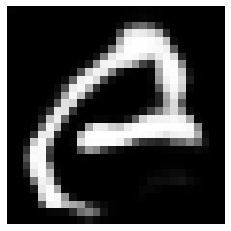

Time for epoch 77 is 8.62496018409729 sec


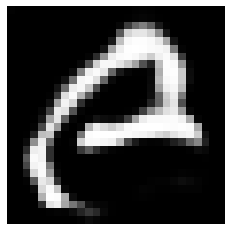

Time for epoch 78 is 8.602214813232422 sec


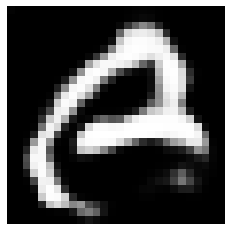

Time for epoch 79 is 8.522950649261475 sec


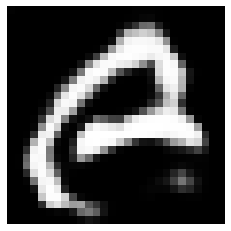

Time for epoch 80 is 8.667539596557617 sec


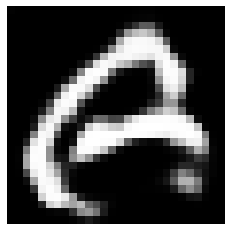

Time for epoch 81 is 8.992817163467407 sec


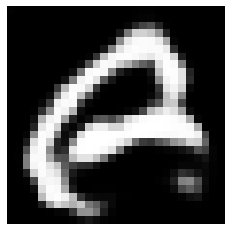

Time for epoch 82 is 9.27726936340332 sec


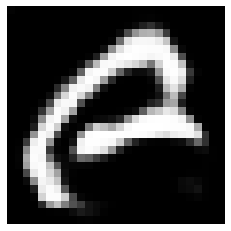

Time for epoch 83 is 8.59788990020752 sec


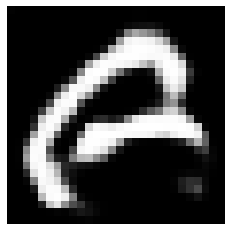

Time for epoch 84 is 8.565433502197266 sec


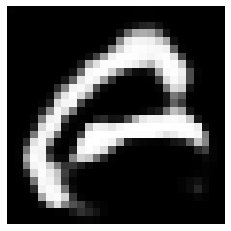

Time for epoch 85 is 8.93465256690979 sec


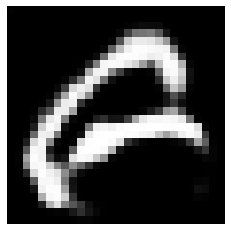

Time for epoch 86 is 8.628458499908447 sec


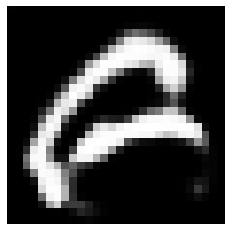

Time for epoch 87 is 8.609590530395508 sec


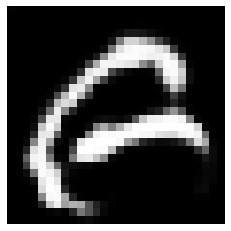

Time for epoch 88 is 8.519614696502686 sec


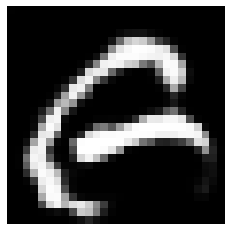

Time for epoch 89 is 8.507283687591553 sec


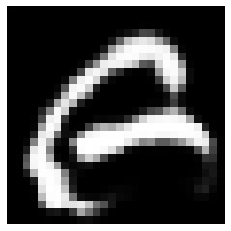

Time for epoch 90 is 8.567124128341675 sec


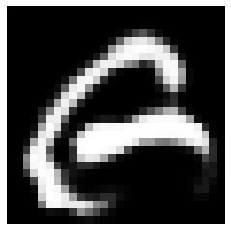

Time for epoch 91 is 8.568203210830688 sec


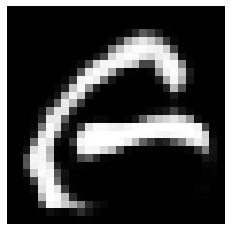

Time for epoch 92 is 8.761956453323364 sec


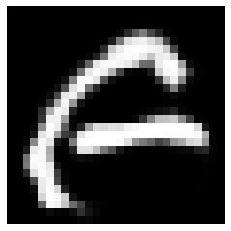

Time for epoch 93 is 8.513990640640259 sec


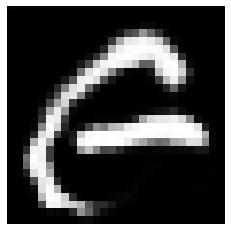

Time for epoch 94 is 8.62655520439148 sec


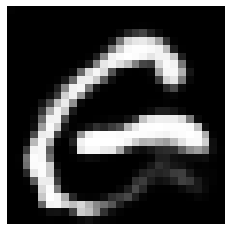

Time for epoch 95 is 8.841193199157715 sec


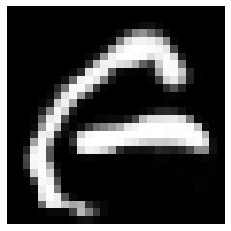

Time for epoch 96 is 8.631982326507568 sec


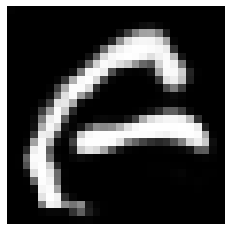

Time for epoch 97 is 8.58831238746643 sec


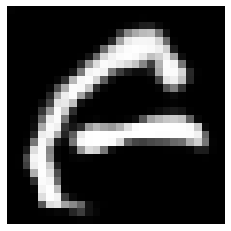

Time for epoch 98 is 8.56733250617981 sec


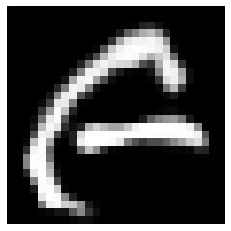

Time for epoch 99 is 8.699088096618652 sec


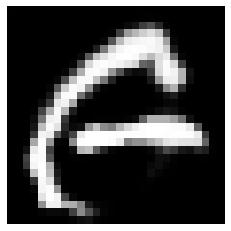

Time for epoch 100 is 8.740139722824097 sec


In [ ]:
#run this code only if there is a runtime disconnection
try:
     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except Exception as error:
    print("Error loading in model : {}".format(error))
train(train_dataset, 100)